# Cell segmentation with Cellpose

In cell biology, identifying cells in microscopic images is a critical step for quantifying many parameters, such as cell death, protein expression, activity, and more. Traditionally, this identification has been done visually by experimenters. However, with recent advancements in computer vision algorithms, this process has become more automated and efficient.

In this **notebook**, I use **Cellpose** for cell segmentation of two-photon calcium recordings. Specifically, I use the latest version developed by Stringer, Pachitariu, and colleagues, **Cellpose-SAM**, which integrates the foundation model **Segment Anything Model (SAM)** ([Kirillov et al., 2023](https://openaccess.thecvf.com/content/ICCV2023/html/Kirillov_Segment_Anything_ICCV_2023_paper.html)) into Cellpose. The original Cellpose used a neural network (U-Net) to predict spatial gradients and then produce masks ([Stringer et al., 2021](https://www.nature.com/articles/s41592-020-01018-x)), whereas Cellpose-SAM adapts SAM's transformer-based architecture to enhance generalization across diverse imaging conditions. For details, see [Pachitariu et al., 2025](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1.full).

**Cellpose** is [well-documented](https://cellpose.readthedocs.io/en/latest/), actively maintained (see the [GitHub repository](https://github.com/MouseLand/cellpose)), and, most importantly, easy to use ([example notebook](https://github.com/MouseLand/cellpose/blob/main/notebooks/run_Cellpose-SAM.ipynb)). Among other outputs, it returns **masks** and regions of interest (ROIs), which can be exported for use in **ImageJ** or Python (ImageJROI).

I have tested several two-photon calcium recordings without training the model, with good results. Post-hoc filtering (e.g., signal-to-noise criteria) can help remove noisy traces and artifacts. In this notebook, I show a simple example of how to apply Cellpose to two short time-series recordings (see below) to calculate and plot the **ΔF/F** traces from the masks identified by Cellpose.

**References**:
- [Cellpose-SAM website](https://huggingface.co/spaces/mouseland/cellpose) To process images online.
- Pachitariu, M., Rariden, M., & Stringer, C. (2025). Cellpose-SAM: superhuman generalization for cellular segmentation. [bioRxiv](https://www.biorxiv.org/content/10.1101/2025.04.28.651001v1.full).


## Installation

**IMPORTANT**: You first need to install [cellpose](https://github.com/MouseLand/cellpose) to use this notebook. Please read the up-to-date instructions on the [cellpose GitHub](https://github.com/MouseLand/cellpose/blob/main/README.md/#Installation). In brief, you need:
1. Open an anaconda prompt or command prompt which has `conda` for python 3 in the path
2. Create a new environment: `conda create --name cellpose python=3.10`
3. Activate the new environment: `conda activate cellpose`
4. Install cellpose: `python -m pip install cellpose[gui]`(with the user interface) or `python -m pip install cellpose` (without the user interface).
5. Install the following packages to run this notebook: `python -m pip install jupyterlab matplotlib pandas`

Note: To use the GPU, you need to install the drivers and the CUDA libraries. 

# Example data: two-photon calcium imaging

Example data come from two-photon calcium imaging recordings of the visual cortex in neonatal mice (see [example video](https://youtu.be/VtAjtu00oKE)). I extracted 15-seconds segments from recordings that were previously motion-corrected using the package [CaImAn](https://caiman.readthedocs.io/en/latest/CaImAn_Tips.html), and were downsampled to a frequency of 7-10 Hz to reduce file size. 
* `2P_GCaMP8m`. Recorded with the GCaMP8m calcium sensor ([Zhang et al., 2023](https://www.nature.com/articles/s41586-023-05828-9)).
* `2P_somaFRCaMPi`. Recorded with the somaFRCaMPi calcium sensor ([Zhou et al., 2025](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3003048)).

For a very accessible and comprehensive introduction to two-photon calcium imaging, I recommend the primer from Grienberger et al., 2022. The two images below are from this paper.

### Two-photon calcium imaging

Briefly, calcium imaging makes use of **fluorescent calcium indicators**, which consist of a protein (e.g., calmodulin) that binds calcium ions (Ca²⁺) ánd is link to a fluorescent protein. When neurons are active (i.e., fire action potentials), voltage-gated calcium channels and NMDA receptors open, allowing Ca²⁺ to enter the cell. Calcium ions then binds to the calcium indicator inside the neuron, increasing fluorescence emission. Since calcium levels can increase up to 100-fold during neuronal activity, the signal-to-noise ratio of calcium imaging is high.


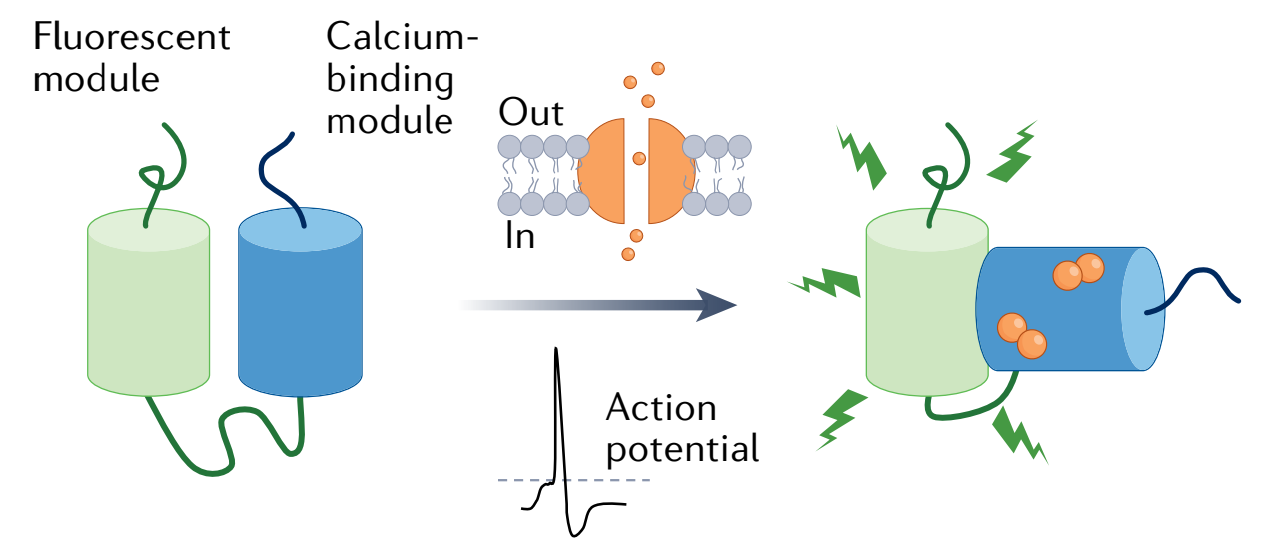

Although the calcium dynamics are slower than action potentials, calcium imaging has become a useful proxy for investigating how neural activity correlates with behavior, pharmacological interventions, and brain disorders. In fact, since the development of **genetically encoded calcium indicators (GECI)** in 2001 ([Nakai et al., 2001](https://pubmed.ncbi.nlm.nih.gov/11175727/)) and, especially, the watershed release of GCaMP6 ([Chen et al., 2013](https://www.nature.com/articles/nature12354)), modern neuroscience can no longer be understood, for better or worse, without calcium imaging. The calcium indicator toolkit now includes dozens of GECIs with different affinities, kinetics, and colors ([Shen et al., 2020](https://www.sciencedirect.com/science/article/pii/S0168010220300389), [Addgene](https://blog.addgene.org/aav-encoded-calcium-sensors)).

The typical pipeline of a **two-photon calcium imaging** experiment in mice for analyzing neuronal activity is as follows:
1. Expression of calcium sensors. GECIs can be expressed across the brain or in very specific subpopulations of neurons using, for example, [viral vectors](https://spikesandbursts.wordpress.com/2024/12/30/adeno-associated-viruses-almost-always-deliver/).
2. Cranial window and two-photon microscopy. A cranial window is created to provide visual access to the brain, and two-photon microscopy is used to image the fluorescent signal of calcium indicators, even in deep brain structures. This allows imaging of dozens to hundreds of neurons simultaneously. For a detailed overview of two-photon microscopy, see [Helmchen and Denk, 2005](https://microscopist.co.uk/files/wp-content/uploads/2017/04/helmchen2005.pdf) and [Svoboda and Yasuda, 2006](https://www.sciencedirect.com/science/article/pii/S0896627306004119).
3. Signal analysis. Recorded movies are then analyzed to extract fluorescence signals and other measures of neuronal activity.

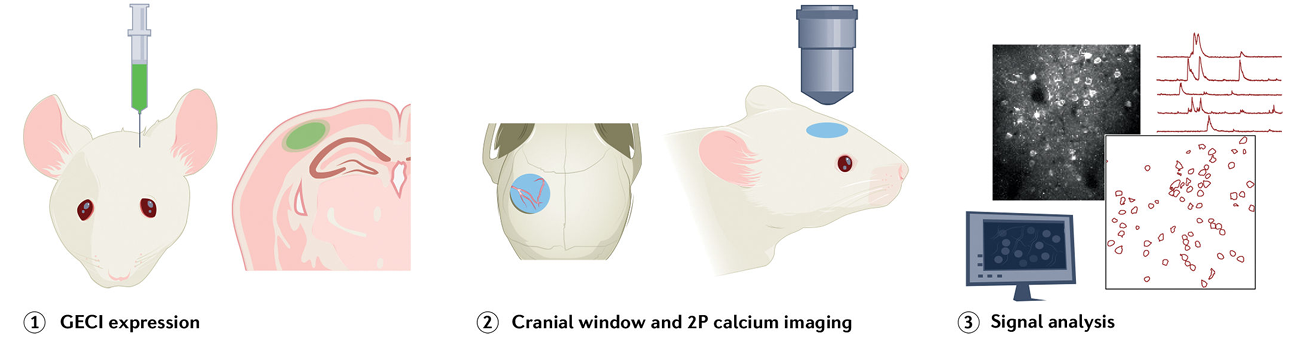

**Further reading**
- Ali and Kwan, 2019. Interpreting in vivo calcium signals from neuronal cell bodies, axons, and dendrites: a review. [Link](https://pmc.ncbi.nlm.nih.gov/articles/PMC6664352/).
- Chen et al., 2013. Ultrasensitive fluorescent proteins for imaging neuronal activity. [Link](https://www.nature.com/articles/nature12354). 
- Grienberger et al., 2022. Two-photon calcium imaging of neuronal activity. [Link](https://pmc.ncbi.nlm.nih.gov/articles/PMC10732251/)
- Grienberger and Konnerth, 2012. Imaging Calcium in Neurons. [Link](https://doi.org/10.1016/j.neuron.2012.02.011). 

# Import the libraries

Note: Once cellpose is installed, you can clone the repository, and run all the cells of this notebook.

In [ ]:
import numpy as np
import re
import os
import sys
import pandas as pd

# Cellpose functions
from cellpose import models, core, io, utils, plot
from cellpose.utils import masks_to_outlines

io.logger_setup() # run this to get printing of progress
model = models.CellposeModel(gpu=False)

import matplotlib.pyplot as plt
# %matplotlib widget  # Interactive plots
plt.rcParams['svg.fonttype'] = 'none' # To generate editable text in saved *.svg plots
plt.close('all')

# Import ROIs from ImageJ
from roifile import ImagejRoi

# Create the paths

In [ ]:
notebook_name = 'cellpose_segmentation_2p'

# Data path to 'Data_example' folders. Change accordingly to your data structure.
data_path = os.path.dirname(os.getcwd())  # Moves one level up from the current directory

# Change the folder names accordingly
paths = {'data': data_path,
         'raw_data':  f'{data_path}/Data_examples/{notebook_name}/',
         'processed_data': f'{data_path}/Processed_data_examples/{notebook_name}/',
         'analysis': f'{data_path}/Analysis_examples/{notebook_name}/',         
         'plots': f'{data_path}/Analysis_examples/{notebook_name}/Plots/'}

# Make folders if they do not exist yet
for path in paths.values():
    os.makedirs(path, exist_ok=True)

# Segmentation parameters

More information about parameters [here](https://cellpose.readthedocs.io/en/latest/settings.html). Default parameters are already quite good, but tuning them can help reduce "false positives." For further fine-tuning, the authors recommend using your own recordings to train the model, which should improve accuracy (see [how](https://github.com/MouseLand/cellpose/blob/main/docs/train.rst)).

- **flow_threshold**: Maximum allowed error of the flows for each mask. **Default: 0.4**. Increase this threshold if Cellpose is not returning as many masks as expected (or turn off completely with 0.0). Decrease it if Cellpose returns too many ill-shaped masks.
- **cellprob_threshold**: Probability threshold that a detected object is a cell. **Default: 0.0**. Decrease this threshold if Cellpose is not returning enough masks or the masks are too small. Increase it if Cellpose returns too many ROIs, particularly from dim areas.
- **tile_norm_blocksize**: Size of the blocks used for image normalization. **Default: 0.0** (entire image normalized together). Set to 100–200 pixels if brightness is very inhomogeneous across the image.
- **niter**: **Default: None or 0**. Sets the number of iterations proportional to the ROI diameter.


In [ ]:
# Cellpose SAM Parameters
flow_threshold = 0.2  # Maximum allowed error of the flows for each mask
cellprob_threshold = 0.5  # Determines proability that a detected object is a cell
tile_norm_blocksize = 0   # Size of blocks used for normalizing the image
niter = None  # Number of iterations. Default is proportional to the ROI diameter.

# Create a dictionary
cellpose_params = {
    "flow_threshold": flow_threshold,
    "cellprob_threshold": cellprob_threshold,
    "tile_norm_blocksize": tile_norm_blocksize,
    "niter": niter}

# Save the dictionary to a text file
with open(f"{paths['analysis']}{notebook_name}_cellpose_params.txt" , "w") as f:
    for key, value in cellpose_params.items():
        f.write(f"{key} = {value}\n")

# Loop for two-photon calcium recordings

This is an example loop that you can adapt to your paths and datasets. After running cellpose, it uses the cell masks to extract and plot the ΔF/F for each mask (∼neuron). For a comprehensive guide on ΔF/F calculation in calcium imaging, see this in-depth article by [Peter Rupprecht](https://www.scientifica.uk.com/learning-zone/how-to-compute-%CE%B4f-f-from-calcium-imaging-data).

In [ ]:
%%time

for dirpath, dirnames, files in os.walk(paths['raw_data']):
    for file in files:
        if file.endswith('.tif'):
            file_path = f"{dirpath}/{file}"
            filename = os.path.splitext(file)[0]

            # Read image and calculate average image
            stack = io.imread(file_path)
            stack_avg = stack.mean(axis=0)

            # Run Cellpose to segment neurons
            masks, flows, styles = model.eval(
                stack_avg,
                batch_size=32,
                flow_threshold=flow_threshold,
                cellprob_threshold=cellprob_threshold,
                normalize={"tile_norm_blocksize": tile_norm_blocksize},
                niter=niter
            )

            # Save masks as both image and numpy array
            masks_path = f"{paths['analysis']}{filename}_masks.tif"
            masks_img = io.imsave(masks_path, masks.astype('uint16'))
            np.save(f"{paths['analysis']}{filename}_masks.npy", masks)

            # Save ROIs for ImageJ (open with ImageJ ROI manager)
            io.save_rois(masks, f"{paths['analysis']}{filename}.zip")  

            # Segmentation images  
            fig = plt.figure(figsize=(12,5))
            plot.show_segmentation(fig, stack_avg, masks, flows[0])
            plt.tight_layout()
            fig.savefig(f"{paths['analysis']}{filename}_segmentation.svg", dpi=300)
            plt.close(fig)    

            # Extract calcium traces from cell masks
            cell_masks = np.unique(masks)  # Get all unique region labels in the masks
            cell_masks = cell_masks[cell_masks != 0]  # Ignore 0 values
               
            traces = []
            for mask in cell_masks:
                cell_mask = (masks == mask)  # Binary mask for the current cell
                mask_pixels = stack[:, cell_mask]  # Get mask pixels over all time frames
                    
                trace = np.nanmean(mask_pixels, axis=1)  # Calculate mean of this cell over time
            
                # DeltaF/F calculation
                f0 = np.median(trace)  # Or using percentiles
                delta_f = (trace - f0) / f0 * 100 if f0 != 0 else np.zeros_like(trace)
                traces.append(delta_f)

            # Save traces to a dataframe
            df_index = np.arange(stack.shape[0]) + 1  # Frames
            df = pd.DataFrame(np.vstack(traces).T, 
                              index=df_index, 
                              columns=[f'n_{mask}' for mask in cell_masks])

            csv_path = f"{paths['analysis']}{filename}_traces.csv"
            df.to_csv(csv_path)
            print(f"Dataframe with deltaF_F traces: {csv_path}")

            # Plot deltaF/F traces (adapt as you wish to suit your preferences)
            n_cell_masks = len(cell_masks)  # One trace per row
            fig, axes = plt.subplots(n_cell_masks, 1, figsize=(4, 0.15 * n_cell_masks), 
                                     sharex=True, sharey=True)
            if n_cell_masks == 1:
                axes = [axes]  # In case only one neuron is detected

            for ax, trace, cell_mask in zip(axes, traces, cell_masks):
                ax.plot(df_index, trace, color='black', linewidth=0.5)
                ax.set_ylabel(f'n_{cell_mask}', rotation=0, labelpad=10, va='center')
                # Remove spines and tick to make the plot cleaner
                ax.spines['top'].set_visible(False)
                ax.spines['right'].set_visible(False)
                ax.spines['left'].set_visible(False)
                ax.spines['bottom'].set_visible(False)
                ax.set_yticks([])
                ax.set_xticks([])

            plt.subplots_adjust(hspace=0.01, left=0.1, right=0.9, top=0.9, bottom=0.01)
            plt.tight_layout(pad=0.5)
            trace_plot_path = f"{paths['analysis']}{filename}_traces.png"  # or svg
            fig.savefig(trace_plot_path, dpi=300)
            plt.close(fig)
            print(f"Traces plot: {trace_plot_path}")

            del stack  # Remove stack from memory

# Import the cellpose ROIs

Exported ROIs can be opened in ImageJ or in Python with ImageJROI ([read documentation](https://github.com/cgohlke/roifile)). Below is just an example of how to load the file. Alternatively, you can load the NumPy array with the masks, which may be easier for extracting traces if you want to reuse them in another script.


In [ ]:
for dirpath, dirnames, files in os.walk(paths['analysis']):
    for file in files:
        if file.endswith('.zip'):
            file_path = f"{dirpath}/{file}"
            filename = os.path.splitext(file)[0]
            rois_path = f"{paths['analysis']}{filename}.zip"
            # Use ImagejRois to load ROIs from file
            rois = ImagejRoi.fromfile(rois_path)  
            for i, roi in enumerate(rois):
                roi.coordinates  # Example to get coordinates from each ROI.